In [1]:
import functools
import os
import concurrent.futures

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate, stats

In [3]:
import lib

In [4]:
shear_step = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [5]:
shear_sim = h5py.File(
    lib.const.SIM_SHEAR_CATALOGS[shear_step],
)

In [6]:
truth_match = h5py.File(
    lib.const.SIM_MATCH_CATALOGS[shear_step],
)

In [7]:
redshift_sim = h5py.File(
    lib.const.SIM_REDSHIFT_CATALOGS[shear_step],
)

In [8]:
zbinsc = redshift_sim["sompz"]["pzdata_weighted_sompz_dz005"]["zbinsc"][:]

nz_sompz = {}
nz_true = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz_sompz = redshift_sim["sompz"]["pzdata_weighted_sompz_dz005"][f"bin{tomographic_bin}"][:]
    _nz_true = redshift_sim["sompz"]["pzdata_weighted_true_dz005"][f"bin{tomographic_bin}"][:]
    
    nz_sompz[tomographic_bin] = _nz_sompz
    nz_true[tomographic_bin] = _nz_true
    

In [9]:
tilenames = np.unique(shear_sim["mdet"]["noshear"]["tilename"][:])

In [10]:
bhat_sim = {}
cell_sim = {}
weight_sim = {}
response_sim = {}

for mdet_step in ["noshear", "1p", "1m"]:
    bhat_sim[mdet_step] = lib.tomography.get_tomography(shear_sim, redshift_sim, mdet_step)
    cell_sim[mdet_step] = lib.tomography.get_assignment(shear_sim, redshift_sim, mdet_step)
    weight_sim[mdet_step] = lib.weight.get_shear_weights(shear_sim["mdet"][mdet_step])
    response_sim[mdet_step] = lib.response.get_shear_response(shear_sim["mdet"][mdet_step])

---

In [11]:
tilename_sim = {}

for mdet_step in ["noshear", "1p", "1m"]:
    tilename_sim[mdet_step] = shear_sim["mdet"][mdet_step]["tilename"][:]

In [12]:
g1_sim = {}

for mdet_step in ["1p", "1m"]:
    g1_sim[mdet_step] = shear_sim["mdet"][mdet_step]["gauss_g_1"][:]

In [13]:
(bhat_sim["1p"] == 0) & (tilename_sim["1p"] == tilenames[0])

array([False, False, False, ..., False, False, False])

In [14]:
def _compute(g1, weight, cell):
    _sum_weight, _, _ = stats.binned_statistic(
        cell,
        weight,
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    _sum_g1, _, _ = stats.binned_statistic(
        cell,
        weight * g1,
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    return _sum_g1, _sum_weight
    

In [15]:
g1_data = {}
w_data = {}
for mdet_step in ["1p", "1m"]:
    _g1_data = []
    _w_data = []
    for tilename in tilenames:
        _sel = (tilename_sim[mdet_step] == tilename)
        _g1, _w = _compute(
            g1_sim[mdet_step][_sel],
            weight_sim[mdet_step][_sel],
            cell_sim[mdet_step][_sel],
        )
        _g1_data.append(_g1)
        _w_data.append(_w)
        
    g1_data[mdet_step] = np.array(_g1_data)
    w_data[mdet_step] = np.array(_w_data)

In [16]:
jackknife = []
for i in range(len(tilenames)):
    _g1_1p = np.sum(np.concatenate([g1_data["1p"][:i], g1_data["1p"][i + 1:]]), axis=0)
    _w_1p = np.sum(np.concatenate([w_data["1p"][:i], w_data["1p"][i + 1:]]), axis=0)

    _g1_1m = np.sum(np.concatenate([g1_data["1m"][:i], g1_data["1m"][i + 1:]]), axis=0)
    _w_1m = np.sum(np.concatenate([w_data["1m"][:i], w_data["1m"][i + 1:]]), axis=0)

    jackknife.append((_g1_1p / _w_1p - _g1_1m / _w_1m) / (2 * 0.01))

jackknife = np.array(jackknife)

In [17]:
_n = len(jackknife)

jackknife_mean = np.mean(jackknife, axis=0)

# jackknife_var = ((_n - 1) / _n) * np.sum(np.square(np.subtract(jackknife, jackknife_mean)), axis=0)
jackknife_std = np.sqrt(((_n - 1) / _n) * np.sum(np.square(np.subtract(jackknife, jackknife_mean)), axis=0))

/global/u2/s/smau/projects/des/y6-image-sims-analysis/notebooks/2025_02_17_tomography/lib/plotting.py:214: UserWarning: Total axes width (6.333333333333333) less than figure width (7.0)
  warnings.warn(f"Total axes width ({total_width}) less than figure width ({fig_width})")


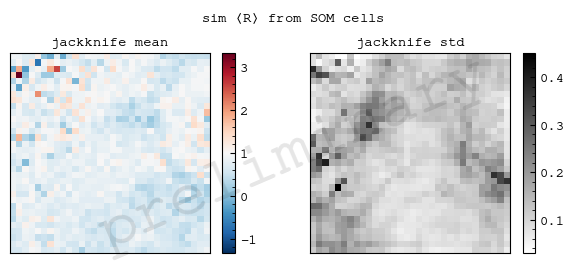

In [18]:
fig, axs = lib.plotting.make_axes(
    1, 2,
    width=2,
    height=2,
    horizontal_margin=8/12,
    vertical_margin=6/12,
    gutter=1,
    fig_width=7,
    fig_height=3,
)

im = axs[0].imshow(
    jackknife_mean.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=mpl.colors.CenteredNorm(1),
    cmap=mpl.cm.RdBu_r,
)
lib.plotting.add_colorbar(axs[0], im)
axs[0].set_title("jackknife mean")

im = axs[1].imshow(
    jackknife_std.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    # norm=mpl.colors.Normalize(0.0, 0.5),
)
lib.plotting.add_colorbar(axs[1], im)
axs[1].set_title("jackknife std")


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])



fig.suptitle("sim $〈R〉$ from SOM cells")

lib.plotting.watermark(fig)

plt.show()

---

In [20]:
z_sim = {}

for mdet_step in ["noshear"]:
    z_sim[mdet_step] = truth_match["mdet"][mdet_step]["z"][:]

In [29]:
g1_som = {}
w_som = {}
w_data = {}
z_data = {}
cell_data = {}

for mdet_step in ["noshear"]:
    _z_data = []
    _w_data = []
    _cell_data = []
    
    for tilename in tilenames:
        _sel = (tilename_sim[mdet_step] == tilename)
        
        _z = z_sim[mdet_step][_sel]
        _z_data.append(_z)

        _w = weight_sim[mdet_step][_sel]
        _w_data.append(_w)

        _cell = cell_sim[mdet_step][_sel]
        _cell_data.append(_cell)

    z_data[mdet_step] = _z_data
    w_data[mdet_step] = _w_data
    cell_data[mdet_step] = _cell_data


for mdet_step in ["1p", "1m"]:
    _g1_data = []
    _w_data = []
    for tilename in tilenames:
        _sel = (tilename_sim[mdet_step] == tilename)
        _g1, _w = _compute(
            g1_sim[mdet_step][_sel],
            weight_sim[mdet_step][_sel],
            cell_sim[mdet_step][_sel],
        )
        _g1_data.append(_g1)
        _w_data.append(_w)
        
    g1_som[mdet_step] = np.array(_g1_data)
    w_som[mdet_step] = np.array(_w_data)

In [33]:
# from Boyan
zbinsc = np.arange(0.035, 4, 0.05)
zedges = np.arange(0.01, 4.02, 0.05)

In [78]:
nz_jackknife = []

for i in range(len(tilenames)):
    print(f"{tilename} {i + 1}/{len(tilenames)}", end="\r", flush=True)
    
    _z_ns = np.concatenate(
        z_data["noshear"][:i] + z_data["noshear"][i + 1:],
    )

    _z_ns[_z_ns < zbinsc[0]] = zbinsc[0] + 0.001
    _z_ns[_z_ns > zbinsc[-1]] = zbinsc[-1] - 0.001

    _w_ns = np.concatenate(
        w_data["noshear"][:i] + w_data["noshear"][i + 1:],
    )
    _cell_ns =np.concatenate(
        cell_data["noshear"][:i] + cell_data["noshear"][i + 1:],
    )
    
    _g1_1p = np.sum(np.concatenate([g1_som["1p"][:i], g1_som["1p"][i + 1:]]), axis=0)
    _w_1p = np.sum(np.concatenate([w_som["1p"][:i], w_som["1p"][i + 1:]]), axis=0)

    _g1_1m = np.sum(np.concatenate([g1_som["1m"][:i], g1_som["1m"][i + 1:]]), axis=0)
    _w_1m = np.sum(np.concatenate([w_som["1m"][:i], w_som["1m"][i + 1:]]), axis=0)

    _R_som = (_g1_1p / _w_1p - _g1_1m / _w_1m) / (2 * 0.01)

    _nz, _, _, _ = stats.binned_statistic_2d(
        _cell_ns,
        _z_ns,
        _w_ns * np.array([
            _R_som[_cell.astype(int)]
            if np.isfinite(_cell) else np.nan
            for _cell in _cell_ns
        ]),
        statistic="sum",
        bins=[lib.const.CELL_IDS, zedges],
    )

    nz_jackknife.append(_nz)

nz_jackknife = np.array(nz_jackknife)

b'DES2359-5831' 981/981

In [79]:
_n = len(nz_jackknife)

nz_jackknife_mean = np.mean(nz_jackknife, axis=0)

nz_jackknife_var = ((_n - 1) / _n) * np.sum(np.square(np.subtract(nz_jackknife, nz_jackknife_mean)), axis=0)
nz_jackknife_std = np.sqrt(((_n - 1) / _n) * np.sum(np.square(np.subtract(nz_jackknife, nz_jackknife_mean)), axis=0))

In [85]:
nz_mean = {}
nz_std = {}

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_mean[tomographic_bin] = np.sum(
        nz_jackknife_mean[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
        axis=0,
    )
    
    nz_std[tomographic_bin] = np.sqrt(
        np.sum(
            nz_jackknife_var[lib.const.CELL_ASSIGNMENTS[tomographic_bin]],
            axis=0,
        ),
    )

    # renormalize
    nz_std[tomographic_bin] = nz_std[tomographic_bin] / np.sum(nz_mean[tomographic_bin]) / np.diff(zedges)  # before mean
    nz_mean[tomographic_bin] = nz_mean[tomographic_bin] / np.sum(nz_mean[tomographic_bin]) / np.diff(zedges)

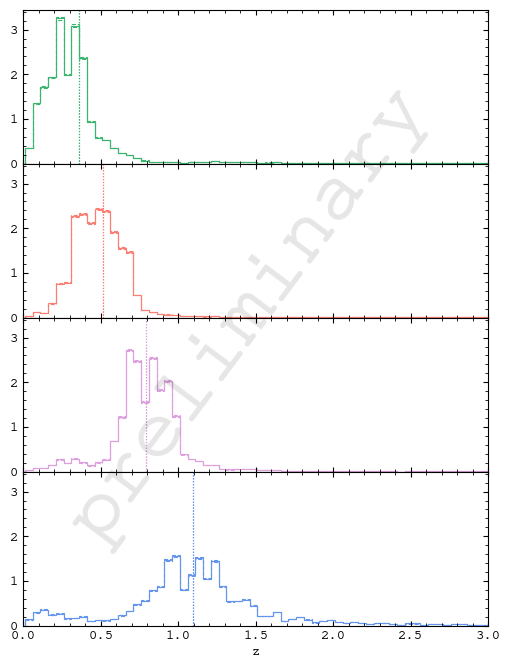

In [86]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:

    axs[i].stairs(
        nz_mean[i] - nz_std[i],
        edges=zedges,
        ec=tomo_colors[i],
        ls="--",
    )
    axs[i].stairs(
        nz_mean[i] + nz_std[i],
        edges=zedges,
        ec=tomo_colors[i],
        ls="--",
    )

    axs[i].axvline(
        np.average(zbinsc, weights=nz_mean[i] - nz_std[i]),
        c=tomo_colors[i],
        ls=":",
    )
    axs[i].axvline(
        np.average(zbinsc, weights=nz_mean[i] + nz_std[i]),
        c=tomo_colors[i],
        ls=":",
    )
    
    axs[i].axvline(
        np.average(zbinsc, weights=nz_mean[i]),
        c=tomo_colors[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_mean[i],
        edges=zedges,
        ec=tomo_colors[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

lib.plotting.watermark(fig)

plt.show()

In [88]:
print("mean z")
print(
    f"--------"
    f"--------"
    f"--------"
    f"--------"
)
print(
    f"bin"
    f"\tμ"
    f"\tμ-σ"
    f"\tμ+σ"
)
for i in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{i}"
        f"\t{np.average(zbinsc, weights=nz_mean[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz_mean[i] - nz_std[i]) :.4f}"
        f"\t{np.average(zbinsc, weights=nz_mean[i] + nz_std[i]) :.4f}"
    )


mean z
--------------------------------
bin	μ	μ-σ	μ+σ
0	0.3606	0.3593	0.3619
1	0.5127	0.5118	0.5136
2	0.7950	0.7947	0.7952
3	1.0931	1.0928	1.0933
